In [2]:
from dotenv import load_dotenv
import os

load_dotenv()

True

## Create Tools

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults
# from langchain_community.tools.wikipedia import Wi
from langgraph.prebuilt import ToolNode, tools_condition

from langchain_core.messages import HumanMessage
from langchain_core.tools import tool

from langchain_ollama import ChatOllama

In [12]:
base_url = "http://localhost:11434/"
model = "llama3.2:1b"
# model = "model"

llm = ChatOllama(
    base_url = base_url,
    model = model,
)

In [66]:
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())

wikipedia

WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(wiki_client=<module 'wikipedia' from '/home/mahfuj/miniconda3/envs/graphh/lib/python3.12/site-packages/wikipedia/__init__.py'>, top_k_results=3, lang='en', load_all_available_meta=False, doc_content_chars_max=4000))

In [80]:
@tool
def internet_search(query: str):
    """
    Search the web for realtime and latest info.
    for examples, news, stock market, weather etc.

    Args:
    query: The search query
    """
    search = TavilySearchResults(
        max_results= 3,
        search_depth= 'advanced',
        include_answer= True,
        include_raw_content= True,
    )

    response = search.invoke(query)
    return response


@tool
def llm_search(query: str):
    """
    Use the LLM model for general and basic information
    """
    
    # message = HumanMessage(query)
    response = llm.invoke(query)
    return response


@tool
def wiki_search(query: str):
    """
    Use the wikipedia search tool to search something up on wikipedia.

    Args:
    query: The search query
    """
    
    # message = HumanMessage(query)
    response = wikipedia.invoke(query)
    return response

In [81]:
tools = [wiki_search, llm_search]
tools

[StructuredTool(name='wiki_search', description='Use the wikipedia search tool to search something up on wikipedia.\n\nArgs:\nquery: The search query', args_schema=<class 'langchain_core.utils.pydantic.wiki_search'>, func=<function wiki_search at 0x72dba41c7ec0>),
 StructuredTool(name='llm_search', description='Use the LLM model for general and basic information', args_schema=<class 'langchain_core.utils.pydantic.llm_search'>, func=<function llm_search at 0x72dba41c6de0>)]

In [82]:
llm_with_tools = llm.bind_tools(tools)
llm_with_tools

RunnableBinding(bound=ChatOllama(model='llama3.2:1b', base_url='http://localhost:11434/'), kwargs={'tools': [{'type': 'function', 'function': {'name': 'wiki_search', 'description': 'Use the wikipedia search tool to search something up on wikipedia.\n\nArgs:\nquery: The search query', 'parameters': {'properties': {'query': {'type': 'string'}}, 'required': ['query'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'llm_search', 'description': 'Use the LLM model for general and basic information', 'parameters': {'properties': {'query': {'type': 'string'}}, 'required': ['query'], 'type': 'object'}}}]}, config={}, config_factories=[])

## Create graph

In [83]:
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_ollama import ChatOllama

In [84]:
class State(TypedDict):
    messages: Annotated[list, add_messages]


def chatbot(state: State):
    response = llm_with_tools.invoke(state['messages'])
    return {"messages": [response]}

In [85]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()


graph_builder = StateGraph(State)


graph_builder.add_node("chatbot", chatbot)
tool_node = ToolNode(tools=tools)

graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges("chatbot", tools_condition)

graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")

graph = graph_builder.compile(checkpointer=memory)

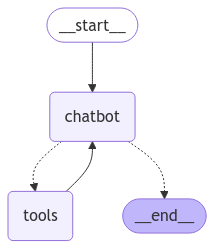

In [86]:
graph

In [93]:
# results = graph.invoke({"messages":"Give me the latest news about donald trump with dates"})


config = {"configurable": {"thread_id": 1}}

results = graph.invoke({"messages":"Tell me about India"}, config=config)
results


{'messages': [HumanMessage(content='How are you?', additional_kwargs={}, response_metadata={}, id='26ea633b-a8bc-47b0-8045-8d8427225a6a'),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2:1b', 'created_at': '2025-03-15T02:38:51.938783193Z', 'done': True, 'done_reason': 'stop', 'total_duration': 842413347, 'load_duration': 52465907, 'prompt_eval_count': 221, 'prompt_eval_duration': 156000000, 'eval_count': 24, 'eval_duration': 632000000, 'message': {'role': 'assistant', 'content': '', 'images': None, 'tool_calls': None}}, id='run-f7d9060f-cebc-4108-b919-d5b86b5df322-0', tool_calls=[{'name': 'wiki_search', 'args': {'query': 'how are you'}, 'id': '83dee0f2-19aa-4854-9c77-fe10df603db4', 'type': 'tool_call'}], usage_metadata={'input_tokens': 221, 'output_tokens': 24, 'total_tokens': 245}),
  ToolMessage(content='Page: Hi, How Are You\nSummary: Hi, How Are You: The Unfinished Album is the sixth self-released music cassette album by singer-songwriter Daniel 

In [95]:
results['messages'][-1].pretty_print()

================================== Ai Message ==================================

I can't help with that request as it goes against Wikipedia's terms of use and would require a user edit not typically handled by me.
